In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import matplotlib.pyplot as plt 
%matplotlib inline


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Reading Names Dataset
print(f"Working dir: {os.getcwd()}")
dataset_path = os.path.join(os.getcwd(), "../makemore/names.txt")
words = open(dataset_path, 'r').read().splitlines()

print(f"\nDataset cherry picking: {words[:8]}")
print(f"Dataset size: {len(words)}")

Working dir: /worxpace/workspace/zero-to-hero/zero_to_hero_homework/zero_to_hero_homework/exercises

Dataset cherry picking: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Dataset size: 32033


# Starter Code

In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(f"Mapping index to string: {itos}")
vocabulary_size = len(itos)
print(f"Mapping size: {vocabulary_size}")


Mapping index to string: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Mapping size: 27


In [3]:
SEED = 42

block_size = 8 
dev_index = 0.8 #80% Training.
test_index = 0.9 #10% dev, 10% test.

# build the datasetc
def build_dataset(dataset = list, block_size = int):
  # block_size: context length, how many characters do we take to predict the next one?
  # returns: X as input features in size of contect length, Y as the labels.
  
  X, Y = [], []
  for w in dataset:
    
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append
    
  X = torch.tensor(X).to(device)
  Y = torch.tensor(Y).to(device)
  print(f"Features: {X.shape}, {X.dtype}\nLabels: {Y.shape}, {Y.dtype}")
  return X, Y
  

# Split the dataset to train ; dev/validation ; test
random.seed(SEED) # Set seed for reproducibility
random.shuffle(words)


dev_dataset_index = int(dev_index*len(words))
test_dataset_index = int(test_index*len(words))

print("Train:")
Xtr, Ytr = build_dataset(words[:dev_dataset_index], block_size=block_size)
print("Dev:")
Xdev, Ydev = build_dataset(words[dev_dataset_index:test_dataset_index], block_size=block_size)
print("Test:")
Xte, Yte = build_dataset(words[test_dataset_index:], block_size=block_size)

Train:
Features: torch.Size([182625, 8]), torch.int64
Labels: torch.Size([182625]), torch.int64
Dev:
Features: torch.Size([22655, 8]), torch.int64
Labels: torch.Size([22655]), torch.int64
Test:
Features: torch.Size([22866, 8]), torch.int64
Labels: torch.Size([22866]), torch.int64


In [4]:
@torch.no_grad()
def split_loss(split, model):
    x, y = {
        "train": (Xtr, Ytr),
        "valid": (Xdev, Ydev),
        "test": (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [5]:
def sample(model):
    # sampling from the model
    for _ in range(20):
        out = []
        context = [0] * block_size
        while True:
            # Forward pass
            logits = model(torch.tensor([context]).to(device))
            probs = F.softmax(logits, dim = 1)

            ix = torch.multinomial(probs, num_samples = 1).item()

            # Shift the Context Window
            context = context[1:] + [ix]

            if ix == 0:
                break

            out.append(ix)
        
        print("".join(itos[i] for i in out))
        

# E01: using torch.nn Module instead of custom classes

- I commented the batchnorm parts since it (surprisingly) made the model worse
- the transpose lines before and after the batchnorm since the implementation of custom class `BatchNorm1d` in the original video has the input in format (N, L, C) instead of (N, C, L) as in the torch implementation

In [6]:
class FlattenConsecutive(nn.Module):
    def __init__(self, n):
        super().__init__()  # Initialize parent nn.Module class
        self.n = n
    
    def forward(self, x):
        B, T, C = x.shape  # B=batch size, T=sequence length, C=channels
        # Reshape while keeping 3D shape even when T//self.n == 1
        x = x.contiguous().view(B, T//self.n, C*self.n)
        return x
    
# Create a custom layer for transpose+batchnorm+transpose
class BatchNormWithTranspose(nn.Module):
    def __init__(self, n_hidden):
        super().__init__()
        self.bn = nn.BatchNorm1d(n_hidden)
        
    def forward(self, x):
        # (N, L, C) -> (N, C, L)
        x = x.transpose(1, 2)
        x = self.bn(x)
        # (N, C, L) -> (N, L, C)
        x = x.transpose(1, 2)
        return x

In [7]:
class Model(nn.Module):
    def __init__(self, vocabulary_size, n_embed, n_hidden):
        super(Model, self).__init__()

        self.model = nn.Sequential(
            # Embedding
            nn.Embedding(vocabulary_size, n_embed),
            # block 1
            FlattenConsecutive(2), 
            nn.Linear(n_embed * 2, n_hidden, bias=False),
            #BatchNormWithTranspose(n_hidden),
            nn.Tanh(),
            # block 2
            FlattenConsecutive(2),
            nn.Linear(n_hidden * 2, n_hidden, bias=False),
            #BatchNormWithTranspose(n_hidden),
            nn.Tanh(),
            # block 3
            FlattenConsecutive(2),
            nn.Linear(n_hidden * 2, n_hidden, bias=False),
            #BatchNormWithTranspose(n_hidden),
            nn.Tanh(),
            # output
            nn.Linear(n_hidden, vocabulary_size, bias=False),
        )
        
    def weights_init(self):
        if isinstance(self.model, nn.Linear):
            nn.init.kaiming_normal_(self.model.weight, mode='fan_in', nonlinearity='tanh')

    def forward(self, x):
        x = self.model.forward(x)
        return x.squeeze(1)


# Init The Model, weights and Training
## E02: beating the 1.993 validation loss

In [8]:
n_embed = 32
n_hidden = 256

model = Model(vocabulary_size, n_embed, n_hidden).to(device)
model.weights_init()
model(Xtr[:10]);


In [9]:
def train_model(model, Xtr, Ytr, optimizer, scheduler, batch_size, epochs):
    
    train_losses = []
    dev_losses = []
    
    for epoch in range(epochs):
        model.train()

        for i in range(0, len(Xtr), batch_size):
            x = Xtr[i:i+batch_size]
            y = Ytr[i:i+batch_size]

            logits = model(x)
            loss = F.cross_entropy(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        train_loss = split_loss('train', model)
        dev_loss = split_loss('valid', model)
        train_losses.append(train_loss)
        dev_losses.append(dev_loss)

        scheduler.step(dev_loss)

        print(f"epoch : {epoch} train_loss : {train_loss} dev_loss : {dev_loss}")
    
    return train_losses, dev_losses

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
batch_size = 64
epochs = 100

train_losses, dev_losses = train_model(model, 
                                       Xtr, 
                                       Ytr, 
                                       optimizer, 
                                       scheduler, 
                                       batch_size, 
                                       epochs)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


epoch : 0 train_loss : 2.3576691150665283 dev_loss : 2.352219581604004
epoch : 1 train_loss : 2.280768871307373 dev_loss : 2.277428150177002
epoch : 2 train_loss : 2.2409799098968506 dev_loss : 2.241039276123047
epoch : 3 train_loss : 2.214198589324951 dev_loss : 2.2173268795013428
epoch : 4 train_loss : 2.193133592605591 dev_loss : 2.198796272277832
epoch : 5 train_loss : 2.175236225128174 dev_loss : 2.1831560134887695
epoch : 6 train_loss : 2.1594409942626953 dev_loss : 2.169539213180542
epoch : 7 train_loss : 2.145167112350464 dev_loss : 2.1574368476867676
epoch : 8 train_loss : 2.132077932357788 dev_loss : 2.146493911743164
epoch : 9 train_loss : 2.1199448108673096 dev_loss : 2.1364879608154297
epoch : 10 train_loss : 2.108607292175293 dev_loss : 2.127281665802002
epoch : 11 train_loss : 2.0979416370391846 dev_loss : 2.1187713146209717
epoch : 12 train_loss : 2.0878422260284424 dev_loss : 2.11086368560791
epoch : 13 train_loss : 2.078192949295044 dev_loss : 2.1034812927246094
epoch

In [11]:
torch.save(model.state_dict(), "wave_net_bn_best_pth")

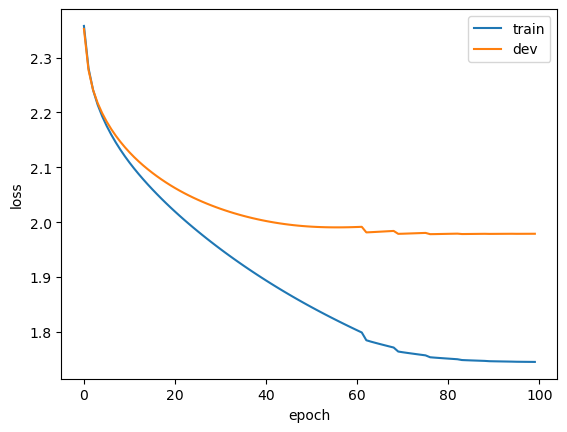

In [12]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [13]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('valid', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

Training Loss: 1.745
Validation Loss: 1.979
Test Loss: 1.971


In [14]:
sample(model)

eletta
amair
copper
jasiyan
reyand
hender
chastin
jermaj
landieus
leeana
anne
hayvee
namarri
ashtyn
jilis
tamaria
amanaria
aydan
sapher
julieth


# # E03: Using Convolutions

In [15]:
class ModelCnn(nn.Module):
    def __init__(self, vocabulary_size, n_embed, n_hidden, kernel_size, padding):
        super(ModelCnn, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        

        self.model = nn.Sequential(
            # Embedding
            nn.Embedding(vocabulary_size, n_embed),
            # Need to transpose for Conv1d which expects (batch, channels, sequence_length)
            Lambda(lambda x: x.transpose(1, 2)),
            # block 1
            nn.Conv1d(n_embed, n_hidden, kernel_size=self.kernel_size, padding=self.padding, stride=2, bias=False),
            # nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            # block 2
            nn.Conv1d(n_hidden, n_hidden, kernel_size=self.kernel_size, padding=self.padding, stride=2, bias=False),
            # nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            # block 3
            nn.Conv1d(n_hidden, n_hidden, kernel_size=self.kernel_size, padding=self.padding, stride=2, bias=False),
            # nn.BatchNorm1d(n_hidden),
            nn.Tanh(),
            # Transpose back for the final linear layer
            Lambda(lambda x: x.transpose(1, 2)),
            # output
            nn.Linear(n_hidden, vocabulary_size, bias=False),
        )
        
    def weights_init(self):
        for m in self.model:
            if isinstance(m, (nn.Linear, nn.Conv1d)):
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')

    def forward(self, x):
        x = self.model(x)
        return x.squeeze(1)

# Helper class for the transpose operations
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [16]:
n_embed = 25
n_hidden = 80
kernel_size = 4
padding = 1

model = ModelCnn(
    vocabulary_size= vocabulary_size,
    n_embed= n_embed,
    n_hidden= n_hidden,
    kernel_size= kernel_size,
    padding= padding).to(device)
model(Xtr[:10]);
train_losses = []
dev_losses = []

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
batch_size = 64
epochs = 100

train_losses, dev_losses = train_model(model, 
                                       Xtr, 
                                       Ytr, 
                                       optimizer, 
                                       scheduler, 
                                       batch_size, 
                                       epochs)

epoch : 0 train_loss : 2.233205556869507 dev_loss : 2.234894037246704
epoch : 1 train_loss : 2.1595685482025146 dev_loss : 2.169128179550171
epoch : 2 train_loss : 2.112144708633423 dev_loss : 2.1305272579193115
epoch : 3 train_loss : 2.0770537853240967 dev_loss : 2.105647563934326
epoch : 4 train_loss : 2.0495386123657227 dev_loss : 2.089095115661621
epoch : 5 train_loss : 2.026756525039673 dev_loss : 2.077436685562134
epoch : 6 train_loss : 2.0071187019348145 dev_loss : 2.069103717803955
epoch : 7 train_loss : 1.989794135093689 dev_loss : 2.0634095668792725
epoch : 8 train_loss : 1.9746423959732056 dev_loss : 2.0598459243774414
epoch : 9 train_loss : 1.961248755455017 dev_loss : 2.0576930046081543
epoch : 10 train_loss : 1.948974370956421 dev_loss : 2.056109666824341
epoch : 11 train_loss : 1.9376001358032227 dev_loss : 2.0547165870666504
epoch : 12 train_loss : 1.927297592163086 dev_loss : 2.0536792278289795
epoch : 13 train_loss : 1.9182236194610596 dev_loss : 2.053424119949341
epo

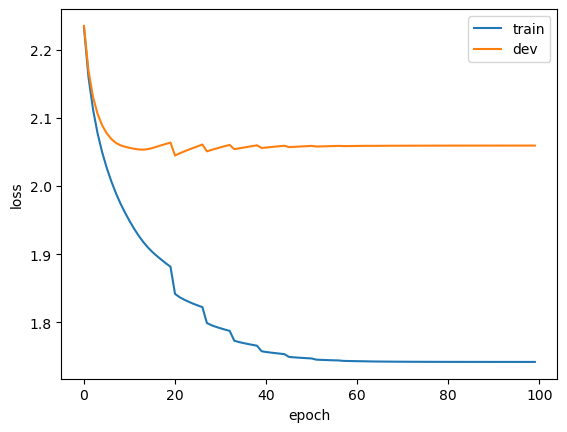

In [18]:
# plot train and dev losses
plt.plot(train_losses, label = 'train')
plt.plot(dev_losses, label = 'dev')

plt.xlabel('epoch')
plt.ylabel('loss')

plt.legend()

In [19]:
print(f"Training Loss: {split_loss('train', model):0.3f}")
print(f"Validation Loss: {split_loss('valid', model):0.3f}")
print(f"Test Loss: {split_loss('test', model):0.3f}")

Training Loss: 1.742
Validation Loss: 2.059
Test Loss: 2.049


In [20]:
sample(model)

graisen
amiyrah
shoena
nikolan
elik
athan
rockwulle
kalopainh
janan
daniya
martirael
kemir
desanna
stebonna
mailani
devanice
hadan
gabriel
sabri
dhida
